# Car Classifer Notebook


## Table of Contents

1. [Packages and Helper Functions](functions)
2. [Balanced Data Set](balanced)
3. [Reduced Classes](reduced)
4. [Reduced and Balanced Classes](reducedbalanced)


## Packages and Helper Functions<a name='functions'>

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

In [33]:
import tensorflow as tf
import re

In [34]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [35]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    image = tf.cast(image, tf.float32) / 255.0 
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {"image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64)}
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.image.resize(example["image"], size=(224, 224))
    label = tf.cast(example['category_id'], tf.int32)
    
    return image, label

def load_dataset(filenames, labeled=True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
    
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = True, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = prefetch(AUTO)
    return dataset

In [36]:
tfrecords_dir = "../input/car-image-train/train"

train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 30
steps_per_epoch = 50
AUTOTUNE = tf.data.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")

In [37]:

CLASSES = ['Fiat_Seicento', 'Toyota_Picnic', 'Volkswagen_Caddy Maxi', 'Isuzu_Rodeo', 'MINI_Paceman', 'Ford_Focus', 
           'Infiniti_Q30', 'Infiniti_Q70', 'Land Rover_Range Rover Sport', 'Subaru_Legacy', 'Mazda_Bongo', 
           'Fiat_Doblo', 'Ford_C-Max', 'Mercedes-Benz_200', 'Nissan_Juke', 'Hyundai_Amica', 'Mercedes-Benz_SLC', 
           'Kia_Venga', 'Kia_Stinger', 'Lexus_LC 500', 'Honda_Elysion', 'Mercedes-Benz_GLA Class', 'Dodge_Avenger', 
           'Fiat_500', 'Ford_Ka', 'Daewoo_Nubira', 'Hyundai_i40', 'Lexus_IS 200', 'Rover_City Rover', 'Land Rover_Freelander', 
           'Jaguar_XKR', 'Toyota_Alphard', 'Ford_Cougar', 'Subaru_WRX STI', 'Infiniti_QX30', 'Ford_Fiesta', 
           'Jaguar_F-Type', 'Hyundai_i10', 'Volkswagen_Golf Plus', 'Jaguar_E-PACE', 'Hyundai_Santa Fe', 'Lexus_RC F', 
           'Mitsubishi_Shogun Pinin', 'Mercedes-Benz_CL', 'Toyota_Auris', 'Fiat_500C', 'Rover_75', 'Honda_Civic', 
           'Suzuki_Wagon R', 'MINI_Unspecified', 'Honda_Integra', 'Volkswagen_Arteon', 'Lexus_IS 300', 'Suzuki_SX4', 
           'Jeep_Wrangler', 'Nissan_Cube', 'Land Rover_Freelander', 'Mercedes-Benz_Citan', 'Volkswagen_Polo', 'Nissan_Almera', 
           'Toyota_Auris', 'Honda_FR-V', 'Toyota_Verso', 'Mazda_CX-5', 'Ford_Escort', 'Volkswagen_Touareg', 'Ford_GT', 
           'Jeep_Grand Cherokee', 'Ford_Focus C-Max', 'Kia_Sorento', 'Volkswagen_Campervan', 'Fiat_Panda', 'Subaru_Levorg', 
           'Volkswagen_California', 'Toyota_RAV4', 'Mercedes-Benz_SLC', 'Volkswagen_Caravelle', 'Hyundai_Matrix', 
           'Nissan_Almera Tino', 'Toyota_Hilux', 'Lexus_GS 250', 'Infiniti_QX30', 'Suzuki_Swift', 'Jeep_Patriot', 
           'Volkswagen_Tiguan Allspace', 'Ford_Mustang', 'Lexus_LS 460', 'Subaru_Forester', 'Lexus_IS 250', 'Mazda_BT-50', 
           'Mitsubishi_Grandis', 'MINI_Clubman', 'Volkswagen_Amarok', 'Saab_9-3', 'Fiat_Barchetta', 'Honda_Jazz', 
           'Hyundai_i800', 'Volkswagen_Bora', 'Honda_Integra', 'Ford_Maverick', 'Volkswagen_Jetta', 'MINI_Roadster', 
           'Volkswagen_Passat', 'DS_4', 'Mercedes-Benz_GLC Class', 'Volkswagen_Polo', 'Hyundai_Sonata', 'Proton_Impian', 
           'Suzuki_Grand Vitara', 'Ford_Mondeo', 'Fiat_Bravo', 'Mitsubishi_Carisma', 'Ford_Focus CC', 'Mitsubishi_Colt Cabriolet', 
           'Lexus_GS 300', 'Suzuki_Alto', 'Kia_Sedona', 'Mitsubishi_Colt Space Star', 'Suzuki_Vitara', 'Toyota_Urbancruiser', 
           'Lexus_RX', 'Toyota_GT86', 'Hyundai_Trajet', 'Infiniti_QX70', 'Mazda_323', 'Mercedes-Benz_V Class', 'Fiat_Stilo', 
           'Kia_Stonic', 'Hyundai_Terracan', 'Mercedes-Benz_A Class', 'Mercedes-Benz_S Class', 'Hyundai_Kona', 'Subaru_XV', 
           'Toyota_Avensis', 'Fiat_Multipla', 'Ford_Streetka', 'Nissan_GT-R', 'Ford_Focus C-Max', 'Toyota_Yaris Verso', 
           'Hyundai_ix20', 'Volkswagen_Sharan', 'MINI_Coupe', 'Ford_Grand C-Max', 'Daihatsu_Terios', 'Mitsubishi_Space Wagon', 
           'Honda_Element', 'Volkswagen_Golf', 'Volkswagen_Tiguan Allspace', 'Toyota_Estima', 'Toyota_GT86', 'Nissan_350 Z', 
           'Toyota_Prius+', 'Suzuki_Celerio', 'Lexus_GS 450h', 'Proton_GEN-2', 'Lexus_NX', 'Fiat_Idea', 'Mercedes-Benz_220', 
           'Ford_Edge', 'Jaguar_XK', 'Honda_Elysion', 'Mercedes-Benz_Viano', 'Fiat_Brava', 'Jaguar_F-PACE', 'Mercedes-Benz_Amg Gt', 
           'Mercedes-Benz_500', 'Land Rover_Defender 110', 'Land Rover_Range Rover', 'Lexus_NX 200t', 'Honda_S2000', 
           'Jaguar_S-Type', 'Mercedes-Benz_G Class', 'Lexus_SC 430', 'Fiat_Punto', 'Toyota_Voxy', 'Hyundai_i40', 'Mazda_Mazda6', 
           'Hyundai_Elantra', 'Honda_CR-Z', 'Kia_Cerato', 'Ford_Freda', 'Fiat_500L', 'Mercedes-Benz_SLR McLaren', 'Toyota_Yaris', 
           'MINI_Clubvan', 'Jaguar_XK8', 'Daihatsu_Copen', 'Toyota_Hilux', 'Land Rover_Discovery 4', 'Toyota_AYGO', 'Kia_Soul', 
           'DS_5', 'Lexus_RX 200t', 'Suzuki_Splash', 'Suzuki_Jimny', 'Volkswagen_Fox', 'Mercedes-Benz_C Class', 'Subaru_Justy', 
           'Mercedes-Benz_CLC Class', 'Ford_Transit Custom', 'Hyundai_Ioniq', 'Volkswagen_Scirocco', 'Infiniti_Q50', 
           'Mitsubishi_Colt', 'Fiat_124 Spider', 'Mitsubishi_Eclipse Cross', 'Infiniti_Q60', 'Jaguar_X-Type', 'Fiat_Tipo', 
           'DS_3 Cabrio', 'Lexus_IS 220d', 'Daihatsu_Materia', 'Lexus_LS 600h', 'Land Rover_Range Rover Evoque', 'Smart_forfour', 
           'Mitsubishi_Carisma', 'Mercedes-Benz_Vito', 'Honda_Accord', 'Toyota_Corolla Verso', 'Ford_Transit Connect', 'Mazda_Mazda5', 
           'Daewoo_Matiz', 'Volkswagen_T-Roc', 'Ford_Ranger', 'Kia_Optima', 'Hyundai_Kona', 'Nissan_Elgrand', 'Mercedes-Benz_CLS', 
           'MINI_Hatch', 'Ford_Grand Tourneo Connect', 'Land Rover_Freelander 2', 'Rover_25', 'Volkswagen_Tiguan', 'Lexus_RX 300', 
           'Ford_Puma', 'Honda_FR-V', 'Mercedes-Benz_CLA Class', 'Ford_Tourneo Custom', 'Hyundai_Veloster', 'Isuzu_D-Max', 
           'Honda_HR-V', 'Mazda_CX-7', 'Lexus_LS 430', 'Infiniti_QX50', 'Mercedes-Benz_GLS Class', 'Jeep_Renegade', 'Mercedes-Benz_SLK', 
           'Mazda_CX-3', 'Toyota_Verso S', 'Lexus_IS', 'MINI_Countryman', 'Ford_Galaxy', 'Fiat_Croma', 'Mercedes-Benz_Vaneo', 
           'Corvette_Stingray', 'Mercedes-Benz_Sprinter', 'Dodge_Charger', 'Kia_Magentis', 'Fiat_Sedici', 'Suzuki_SX4 S-Cross', 
           'Infiniti_EX', 'Suzuki_Vitara', 'Kia_Sorento', 'Hyundai_Getz', 'Ford_Tourneo Connect', 'Isuzu_Rodeo', 'Rover_75 Tourer', 
           'Volkswagen_Touran', 'MINI_Convertible', 'Kia_Carens', 'Lexus_RX 350', 'Jeep_Commander', 'Dodge_Nitro', 'Volkswagen_up!', 
           'Jeep_Compass', 'Land Rover_Discovery Sport', 'Smart_fortwo', 'Land Rover_Discovery 3', 'Jaguar_XK8', "Kia_Pro_Cee'd", 
           'Mercedes-Benz_A Class', 'Jaguar_XE', 'Fiat_Punto Evo', 'DS_4 Crossback', 'Tesla_Model S', 'Jeep_Compass', "Kia_Cee'd", 
           'Jaguar_XF', 'Toyota_Urbancruiser', 'Smart_Roadster', 'Hyundai_Trajet', 'Toyota_iQ', 'Mercedes-Benz_B Class', 'Daihatsu_Sirion', 
           'Toyota_MR2', 'Hyundai_Genesis', 'Daewoo_Matiz', 'Volkswagen_Arteon', 'Mercedes-Benz_E Class', 'Mercedes-Benz_SL Class', 
           'DS_3 Cabrio', 'Honda_NSX', 'Subaru_Tribeca', 'Kia_Sportage', 'Subaru_Tribeca', 'Ford_S-Max', 'TVR_Sagaris', 'Mazda_Mazda3', 
           'Mitsubishi_Shogun', 'Mazda_MX-5', 'Nissan_e-NV200', 'Toyota_Proace', 'Mercedes-Benz_350', 'Mazda_Mazda2', 'Mercedes-Benz_X Class', 
           'Land Rover_Discovery', 'Fiat_Grande Punto', 'Honda_Accord', 'Volkswagen_CC', 'Proton_Savvy', 'Saab_9-5', 'Nissan_e-NV200', 
           'Toyota_Previa', 'Infiniti_G', 'Kia_Rio', 'Infiniti_FX', 'Kia_Niro', 'Mercedes-Benz_B Class', 'Volkswagen_Eos', 'Mercedes-Benz_R Class', 
           'Mercedes-Benz_Citan Traveliner', 'Mitsubishi_Space Star', 'Hyundai_Tucson', 'Jeep_Commander', 'Volkswagen_Beetle', 'Lexus_CT', 
           'Lexus_RX 400h', 'Volkswagen_Transporter Sportline', 'Lexus_RC 300h', 'Subaru_Outback', 'Lexus_NX 300h', 'Ford_EcoSport', 
           'Volkswagen_Caddy Maxi Life', 'Mazda_BT-50', 'Toyota_Voxy', 'Mazda_Tribute', 'Mitsubishi_Shogun Sport', 'Suzuki_Jimny', 'Lexus_RC', 
           'DS_3', 'Mitsubishi_Lancer', 'Toyota_Corolla', 'Nissan_Almera Tino', 'Ford_Explorer', 'Suzuki_Ignis', 'Land Rover_Range Rover Velar', 
           'Volkswagen_Amarok', 'Mercedes-Benz_SLS', 'Mercedes-Benz_CLK', 'Fiat_500X', 'Kia_Picanto', 'Hyundai_ix35', 'Ford_Fusion', 
           'Honda_Stepwagon', 'Fiat_Qubo', 'Dodge_Caliber', 'Toyota_Land Cruiser', 'Toyota_PROACE Verso', 'Lexus_RX 450h', 'Rover_45', 
           'Mitsubishi_ASX', 'Volkswagen_Golf SV', 'Mercedes-Benz_GLE Class', 'Suzuki_Baleno', 'Mitsubishi_Mirage', 'Lexus_IS 200', 
           'Mitsubishi_L200', 'Jaguar_XF', 'Fiat_Bravo', 'Mazda_RX-8', 'Volkswagen_Transporter Shuttle', 'Ford_Kuga', 'Honda_Insight', 
           'Hyundai_Tucson', 'Hyundai_Grandeur', 'Volkswagen_Transporter', 'Kia_Cerato', 'Toyota_Prius', 'Jaguar_XJ', 'Toyota_Land Cruiser Amazon', 
           'Toyota_C-HR', 'Subaru_Impreza', 'Hyundai_i20', 'Subaru_BRZ', 'Ford_B-Max', 'Kia_Optima', 'Hyundai_Accent', 'Ford_Mustang', 'Honda_CR-Z',
           'Mercedes-Benz_M Class', 'Suzuki_Splash', 'Volkswagen_Phaeton', 'Fiat_Fullback', 'Mitsubishi_Outlander', 'Fiat_Fiorino', 
           'Lexus_CT 200h', 'Lexus_NX Unspecified', 'Daewoo_Kalos', 'Ford_Edge', 'Suzuki_Liana', 'Mazda_MX-5 RF', 'Volkswagen_Jetta', 'Lexus_CT', 'Jeep_Cherokee', 
           'Land Rover_Defender 90', 'Nissan_370 Z', 'Ford_Kuga', 'Hyundai_Coupe', 'Tesla_Model X', 'Ford_Ka+', 'Hyundai_i30', 
           'Honda_NSX', 'Mercedes-Benz_GL Class', 'Toyota_Surf', 'Hummer_H2', 'Honda_CR-V', 'Volkswagen_Caddy']


## Preliminary Model

In [38]:
#model.summary()

In [39]:
#model.save("EfficientNetCar.h5")


## Balanced Data Set

In [40]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.25
balanced_data_files = tf.io.gfile.glob(GCS_PATH + 'balancedcartrain/balanced_train/*.tfrec')
split = len(balanced_data_files) - int(len(balanced_data_files) * val_split)

BALANCED_TRAINING_FILENAMES = balanced_data_files[:split]

BALANCED_VALIDATION_FILENAMES = balanced_data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'car-image-test/test/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(BALANCED_TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(BALANCED_VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 34508 training images, 8192 validation images, 35786 test images


In [41]:
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=427
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(BALANCED_TRAINING_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=2,
)

Epoch 1/30
50/50 - 18s - loss: 6.3711 - sparse_categorical_accuracy: 0.0025
Epoch 2/30
50/50 - 10s - loss: 6.1561 - sparse_categorical_accuracy: 0.0019
Epoch 3/30
50/50 - 10s - loss: 6.1311 - sparse_categorical_accuracy: 0.0019
Epoch 4/30
50/50 - 10s - loss: 6.1210 - sparse_categorical_accuracy: 0.0019
Epoch 5/30
50/50 - 10s - loss: 6.1605 - sparse_categorical_accuracy: 0.0012
Epoch 6/30
50/50 - 10s - loss: 6.1515 - sparse_categorical_accuracy: 0.0025
Epoch 7/30
50/50 - 10s - loss: 6.1524 - sparse_categorical_accuracy: 0.0012
Epoch 8/30
50/50 - 10s - loss: 6.1414 - sparse_categorical_accuracy: 0.0031
Epoch 9/30
50/50 - 10s - loss: 6.1685 - sparse_categorical_accuracy: 0.0025
Epoch 10/30
50/50 - 10s - loss: 6.1579 - sparse_categorical_accuracy: 0.0019
Epoch 11/30
50/50 - 10s - loss: 6.1540 - sparse_categorical_accuracy: 0.0019
Epoch 12/30
50/50 - 10s - loss: 6.1500 - sparse_categorical_accuracy: 0.0012
Epoch 13/30
50/50 - 10s - loss: 6.1433 - sparse_categorical_accuracy: 0.0019
Epoch 14

In [42]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

In [43]:
IMAGE_SIZE = [224, 224]

pretrained_vgg_model = tf.keras.applications.vgg16.VGG16(
        weights=None,
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
#for layer in pretrained_vgg_model.layers:
 #   if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
 #       layer.trainable = True
 #   else:
 #        layer.trainable = False
    
vgg_model = tf.keras.Sequential([
    # To a base pretrained on ImageNet to extract features from images...
    pretrained_vgg_model,
    # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [44]:
pretrained_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [45]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.01)

#vgg_model.compile(
 #   optimizer=optimizer,
  #  loss = 'sparse_categorical_crossentropy',
   # metrics=['sparse_categorical_accuracy'],
#)

#vgg_model.summary()

In [46]:

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [47]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

inception_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_7 (Dense)              (None, 427)               213927    
Total params: 23,041,211
Trainable params: 1,238,427
Non-trainable params: 21,802,784
_________________________________________________________________


In [48]:
inception_history = inception_model.fit(
    x=get_dataset(BALANCED_TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(BALANCED_VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
50/50 - 20s - loss: 7.6956 - sparse_categorical_accuracy: 0.0025 - val_loss: 6.0499 - val_sparse_categorical_accuracy: 0.0033
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.008009999821186066.
50/50 - 16s - loss: 6.0632 - sparse_categorical_accuracy: 0.0019 - val_loss: 6.0660 - val_sparse_categorical_accuracy: 0.0024
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.004825999994277954.
50/50 - 15s - loss: 6.0699 - sparse_categorical_accuracy: 0.0012 - val_loss: 6.0671 - val_sparse_categorical_accuracy: 0.0017
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.0019603999841213225.
50/50 - 16s - loss: 6.0688 - sparse_categorical_accuracy: 6.2500e-04 - val_loss: 6.0669 - val_sparse_categorical_accuracy: 0.0024
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 0.0004320800052583216.
50/50 - 15s - loss: 

In [49]:
test_dataset = get_dataset(TEST_FILENAMES, batch_size)

In [50]:
labels = list(map(lambda x: x[1], test_dataset) )

In [51]:
correct_labels = [item for sublist in labels for item in sublist]

In [52]:
model_probabilities = model.predict(test_dataset)
model_predictions = np.argmax(model_probabilities, axis = -1)

In [53]:
 label_nums = range(len(CLASSES))

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [55]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15, 15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="center", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="center", rotation_mode="anchor")
    titlestring=""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment': 'right', 'verticalalignment': 'top', 'color':'#804040'})
    plt.show()
    

In [56]:
model_f1_score = f1_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_precision = precision_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_recall = recall_score(correct_labels, model_predictions, labels=label_nums, average='macro', zero_division = 0)

model_cmat = confusion_matrix(correct_labels, model_predictions, labels=label_nums)

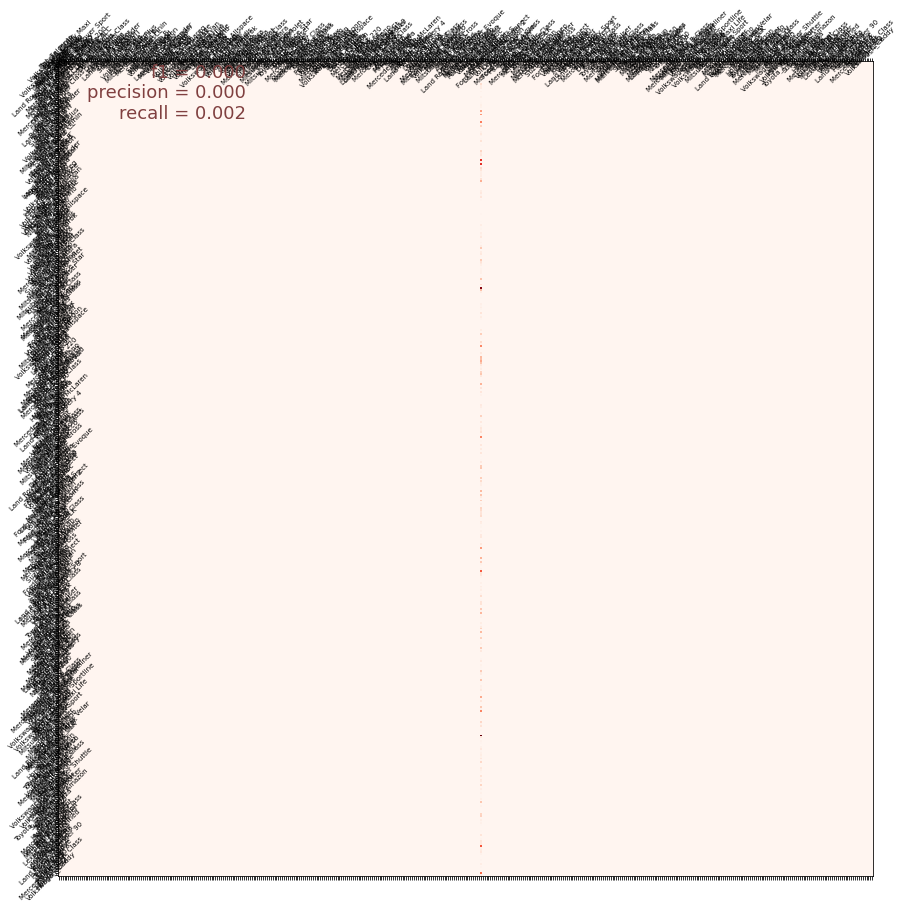

In [57]:
display_confusion_matrix(model_cmat, model_f1_score,model_precision,  model_recall)

In [58]:
pred_list = list(model_predictions)
for i in np.unique(model_predictions):
    print(i, pred_list.count(i))

0 2235
221 33549
355 2


In [59]:
CLASSES[191]

'DS_5'

### Balanced Data set Model Evaluation

## Reduced Classes

These sets have had the classes reduced to just car brand and the model is omitted

In [60]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.20
data_files = tf.io.gfile.glob(GCS_PATH + 'carmodel/train_new_set/*.tfrec')
split = len(data_files) - int(len(data_files) * val_split)

TRAINING_FILENAMES = data_files[:split]

VALIDATION_FILENAMES = data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'carmodeltest/test_new_set/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 517225 training images, 126976 validation images, 71578 test images


In [61]:

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

reduced_efficient_model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=26
)


reduced_efficient_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

#vgg_history = model.fit(
#    x=get_dataset(TRAINING_FILENAMES, batch_size),
#    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
#    epochs=epochs,
#    steps_per_epoch=steps_per_epoch,
#    callbacks=[lr_callback],
#    verbose=2
#)
#model.fit(
#    x=get_dataset(TRAINING_FILENAMES, batch_size),
#    epochs=epochs,
#    steps_per_epoch=steps_per_epoch,
#    verbose=2,
#)
efficient_history = reduced_efficient_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
50/50 - 200s - loss: 3.6104 - sparse_categorical_accuracy: 0.1363 - val_loss: 2.8120 - val_sparse_categorical_accuracy: 0.1368
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008100000379979611.
50/50 - 191s - loss: 3.1043 - sparse_categorical_accuracy: 0.1825 - val_loss: 2.7378 - val_sparse_categorical_accuracy: 0.2012
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005060000335611404.
50/50 - 191s - loss: 3.0538 - sparse_categorical_accuracy: 0.2006 - val_loss: 2.7394 - val_sparse_categorical_accuracy: 0.2012
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.00023240000449121004.
50/50 - 191s - loss: 2.9444 - sparse_categorical_accuracy: 0.1825 - val_loss: 2.7431 - val_sparse_categorical_accuracy: 0.2012
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
50/50 - 191s - l

In [62]:
reduced_efficient_model.save("EfficientNetCarMake.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [63]:
IMAGE_SIZE = [224, 224]

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
reduced_inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    ])

In [64]:
reduced_inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

reduced_inception_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_9 (Dense)              (None, 26)                13026     
Total params: 22,840,310
Trainable params: 1,037,526
Non-trainable params: 21,802,784
_________________________________________________________________


In [65]:
reduced_inception_history = reduced_inception_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 1.112589961849153e-05.
50/50 - 204s - loss: 2.9056 - sparse_categorical_accuracy: 0.1663 - val_loss: 2.6834 - val_sparse_categorical_accuracy: 0.2054
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 1.8900719694793224e-05.
50/50 - 198s - loss: 2.7314 - sparse_categorical_accuracy: 0.2069 - val_loss: 2.5827 - val_sparse_categorical_accuracy: 0.2337
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 3.134043232013937e-05.
50/50 - 198s - loss: 2.6624 - sparse_categorical_accuracy: 0.2256 - val_loss: 2.5383 - val_sparse_categorical_accuracy: 0.2581
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 4.253617228940129e-05.
50/50 - 197s - loss: 2.5750 - sparse_categorical_accuracy: 0.2406 - val_loss: 2.5040 - val_sparse_categorical_accuracy: 0.2673
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 4.850723445182666e-05.
50/50 - 197s - l

In [66]:
reduced_inception_model.save("InceptionNetCar.h5")

### Reduced class model evaluation

In [67]:
test_dataset = get_dataset(TEST_FILENAMES, batch_size)
labels = list(map(lambda x: x[1], test_dataset) )
correct_labels = [item for sublist in labels for item in sublist]

In [68]:
CLASSES = ['DS',
 'Dodge',
 'Fiat',
 'Ford',
 'Honda',
 'Hyundai',
 'Infiniti',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'Kia',
 'Land Rover',
 'Lexus',
 'MINI',
 'Mazda',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Rover',
 'Saab',
 'Smart',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Unknown',
 'Volkswagen']

In [69]:
len(CLASSES)

26

In [70]:
reduced_inception_model_probabilities = reduced_inception_model.predict(test_dataset)
reduced_inception_model_predictions = np.argmax(reduced_inception_model_probabilities, axis = -1)

In [71]:
pred_list = list(reduced_inception_model_predictions)
for i in np.unique(reduced_inception_model_predictions):
    print(CLASSES[i], pred_list.count(i))
    

DS 7405
Fiat 6101
Ford 15
Honda 877
Hyundai 11
Isuzu 495
Land Rover 36340
MINI 30
Mazda 113
Mitsubishi 3052
Rover 14138
Saab 267
Smart 35
Subaru 1435
Toyota 1038
Unknown 226


In [72]:
reduced_inception_model_f1_score = f1_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_precision = precision_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_recall = recall_score(correct_labels, reduced_inception_model_predictions, labels=label_nums, average='macro', zero_division = 0)

reduced_inception_model_cmat = confusion_matrix(correct_labels, reduced_inception_model_predictions, labels=label_nums)

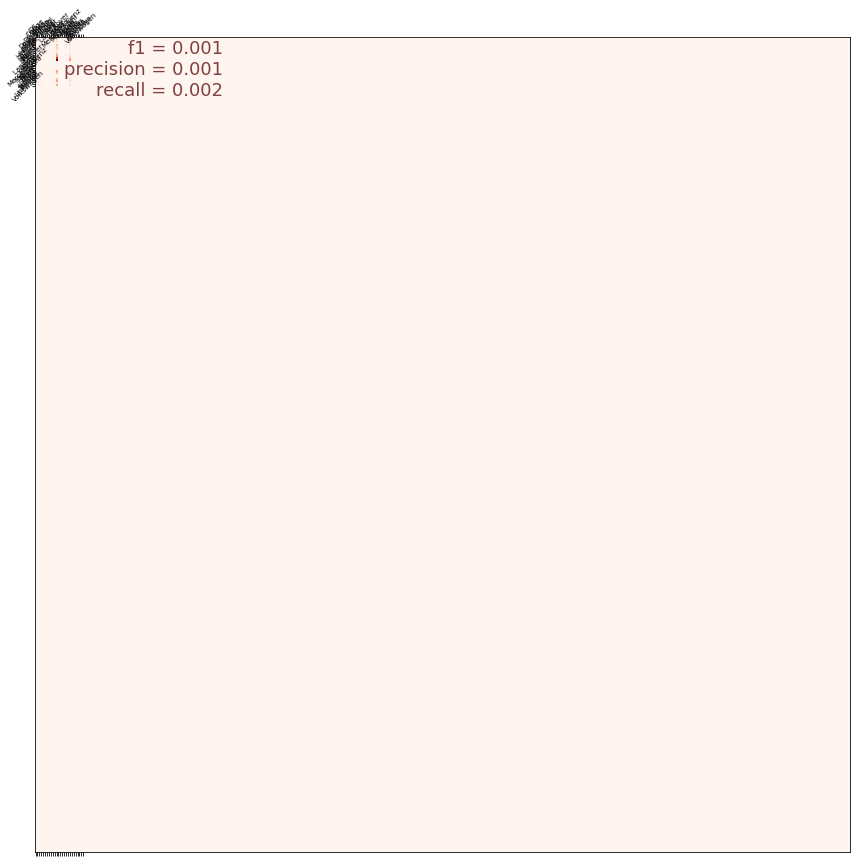

In [73]:
display_confusion_matrix(reduced_inception_model_cmat, reduced_inception_model_f1_score, reduced_inception_model_precision,  reduced_inception_model_recall)


## Reduced and Balanced Classes

In [74]:
GCS_PATH =  '../input/'
AUTO = tf.data.experimental.AUTOTUNE

val_split = 0.25
data_files = tf.io.gfile.glob(GCS_PATH + 'balanced-reduced-train/balanced_train_reduced_classes/*.tfrec')
split = len(data_files) - int(len(data_files) * val_split)

TRAINING_FILENAMES = data_files[:split]

VALIDATION_FILENAMES = data_files[split:]
TEST_FILENAMES =  tf.io.gfile.glob(GCS_PATH + 'carmodeltest/test_new_set/*.tfrec')

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 11140 training images, 4096 validation images, 71578 test images


In [75]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

balanced_model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=26
)


balanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


balanced_efficient_history = balanced_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
50/50 - 26s - loss: 4.1550 - sparse_categorical_accuracy: 0.0413 - val_loss: 3.3124 - val_sparse_categorical_accuracy: 0.0396
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008100000379979611.
50/50 - 17s - loss: 3.7918 - sparse_categorical_accuracy: 0.0538 - val_loss: 3.3431 - val_sparse_categorical_accuracy: 0.0354
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005060000335611404.
50/50 - 16s - loss: 3.5656 - sparse_categorical_accuracy: 0.0506 - val_loss: 3.3708 - val_sparse_categorical_accuracy: 0.0366
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.00023240000449121004.
50/50 - 17s - loss: 3.4540 - sparse_categorical_accuracy: 0.0556 - val_loss: 3.3695 - val_sparse_categorical_accuracy: 0.0378
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
50/50 - 16s - loss: 

In [76]:
IMAGE_SIZE = [224, 224]

pretrained_inception_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False ,
    input_shape=[*IMAGE_SIZE, 3]
    )
for layer in pretrained_inception_model.layers:
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        layer.trainable = True
    else:
        layer.trainable = False
    
pretrained_inception_model = tf.keras.Sequential([
       # To a base pretrained on ImageNet to extract features from images...
    pretrained_inception_model,
        # ... attach a new head to act as a classifier.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
    ])

In [77]:
pretrained_inception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

pretrained_inception_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               1024500   
_________________________________________________________________
dense_11 (Dense)             (None, 26)                13026     
Total params: 22,840,310
Trainable params: 1,037,526
Non-trainable params: 21,802,784
_________________________________________________________________


In [78]:
pretrained_inception_history = pretrained_inception_model.fit(
    x=get_dataset(TRAINING_FILENAMES, batch_size),
    validation_data=get_dataset(VALIDATION_FILENAMES, batch_size),
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback],
    verbose=2
)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 1.0188894520979375e-05.
50/50 - 15s - loss: 3.4739 - sparse_categorical_accuracy: 0.0456 - val_loss: 3.2437 - val_sparse_categorical_accuracy: 0.0571
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 1.81511156167835e-05.
50/50 - 9s - loss: 3.3110 - sparse_categorical_accuracy: 0.0569 - val_loss: 3.1139 - val_sparse_categorical_accuracy: 0.1035
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 3.089066900021862e-05.
50/50 - 9s - loss: 3.1550 - sparse_categorical_accuracy: 0.0869 - val_loss: 3.0443 - val_sparse_categorical_accuracy: 0.1160
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 4.2356266961432993e-05.
50/50 - 9s - loss: 3.1038 - sparse_categorical_accuracy: 0.1069 - val_loss: 2.9698 - val_sparse_categorical_accuracy: 0.1313
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 4.8471253386233007e-05.
50/50 - 10s - loss: 3.

In [79]:
pretrained_inception_model.save("InceptionNetCar2.h5")

## Test on cropped car image

In [80]:
from PIL import Image
test_image = Image.open('../input/test-image/test_image.jpg')


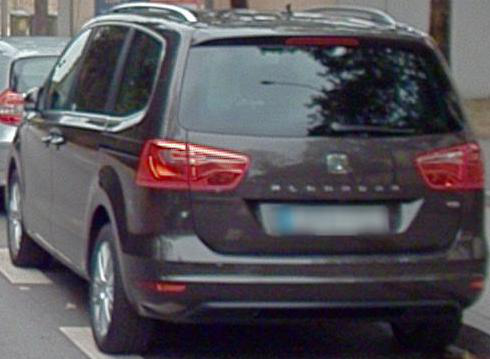

In [81]:
test_image

In [82]:
image = np.array(test_image, dtype='uint8')

In [83]:
image = tf.convert_to_tensor(image)


In [84]:

image = tf.image.resize(image, size=(224, 224))
image = tf.cast(image, tf.float32) / 255.0 
image = np.expand_dims(image, axis=0)

In [85]:
image.shape


(1, 224, 224, 3)

In [86]:
pred = pretrained_inception_model.predict(image)

In [87]:
class_pred = np.argmax(pred) 
class_pred

8